In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import re 
from bs4 import BeautifulSoup 

from gensim.models import ldamodel
import gensim.corpora
import networkx as nx
from statistics import mean
from collections import Counter
import itertools

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping

In [ ]:
amazon = pd.read_csv('amazon_comment_seaweed_chip_result.csv')
amazon = amazon.drop(amazon.columns[0], axis = 1)
walmart = pd.read_csv('walmart.csv') 
youtube_1 = pd.read_excel('youtube_script1.xlsx')
youtube_1 = youtube_1.drop(youtube_1.columns[0], axis = 1)
youtube_2 = pd.read_excel('youtube_script2.xlsx')
youtube_2 = youtube_2.drop(youtube_2.columns[0], axis = 1)

In [ ]:
def name_cut(x):
    x = x.split('on ')[1]
    return x  

amazon["comment_date"] = amazon["comment_date"].apply(name_cut)

def name_cut(x):
    x = x.split(" out")[0]
    x = float(x)
    return x  

amazon["star_rating"] = amazon["star_rating"].apply(name_cut)

In [ ]:
review = pd.concat([amazon['comment'], walmart['comment']], axis = 0) 
score = pd.concat([amazon['star_rating'], walmart['score']], axis = 0) 
author = pd.concat([amazon['comment_author'], walmart['author']], axis = 0)
date = pd.concat([amazon['comment_date'], walmart['date']], axis = 0)
title = pd.concat([amazon['comment_title'], walmart['title']], axis = 0)

review = pd.DataFrame({'date': date, 'title' : title, 'review': review, 'score': score, 'author': author})

In [ ]:
stop_words = set(stopwords.words("english"))
stop_words.update(("yum", "yummy", "love", "loves", "great", "good", "better", "amazing", "buying", "found", "get", "like", "loved", 'maybe', 'may', 'could', 'awesome', 
                   'definitely', 'perfect' , 'best', 'okay', 'excellent', 'disappointed', 'right', 'nice', 'however', 'maybe', 'pretty', 'thank', 'wonderful', 'terrible', 
                   'unfortunately', 'awful', 'horrible', 'worst', 'wont', 'surprised', 'one', 'bad', 'actually', 'really', 'would',
                    'everybody', 'sometime', 'state', 'generally', 'edge', 'report', 'gross'
))
stemmer = SnowballStemmer("english")
TEXT_CLEANING_RE = "\([^)]*\|s\b|@\S+|https?:\S+|http?:\S|[^a-zA-Z]+"

In [ ]:
contraction_mapping = {"won't": "will not",  "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                       "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                       "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                       "you're": "you are", "you've": "you have"}

In [ ]:
def preprocess(text, stem=False):
    newString = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  

    tokens = []
    for token in newString.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
review['cleaned_review'] = review['review'].apply(lambda x: preprocess(x))

In [ ]:
review.isnull().sum()

date              0
title             1
review            1
score             0
author            1
cleaned_review    0
dtype: int64

In [ ]:
review[review['review'].isnull()]

,date,title,review,score,author,cleaned_review
2127,"June 4, 2018",The packaging sucks very disappointed,NaN,1.0,Sydney,nan


In [ ]:
review.replace(' ',np.nan , inplace = True)
review.dropna(axis = 0 , inplace = True, subset = ['review'])

In [ ]:
df = review
X = df['cleaned_review']
y_dict = {1.0:0, 2.0:0, 3.0:1, 4.0:1, 5.0:1}
y = df['score'].map(y_dict)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                stratify=y, 
                                                random_state=42, 
                                                test_size=0.2, shuffle=True)

In [ ]:
print (x_train.shape)
print (x_test.shape)

(4622,)
(1156,)


# Building Basic Models

In [ ]:
def model_Evaluate(model, x_test):
    
    # Predict values for Test dataset
    y_pred = model.predict(x_test)

    # Print the evaluation metrics for the dataset.
    print(model.score(x_test, y_test))
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    
prediction = dict()

## CountVectorizer

In [ ]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 2))

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(x_train) + list(x_test))
xtrain_ctv =  ctv.transform(x_train) 
xtest_ctv = ctv.transform(x_test)

### - Logistic Regression

0.9039792387543253
              precision    recall  f1-score   support

           0       0.84      0.47      0.60       179
           1       0.91      0.98      0.95       977

    accuracy                           0.90      1156
   macro avg       0.88      0.73      0.77      1156
weighted avg       0.90      0.90      0.89      1156



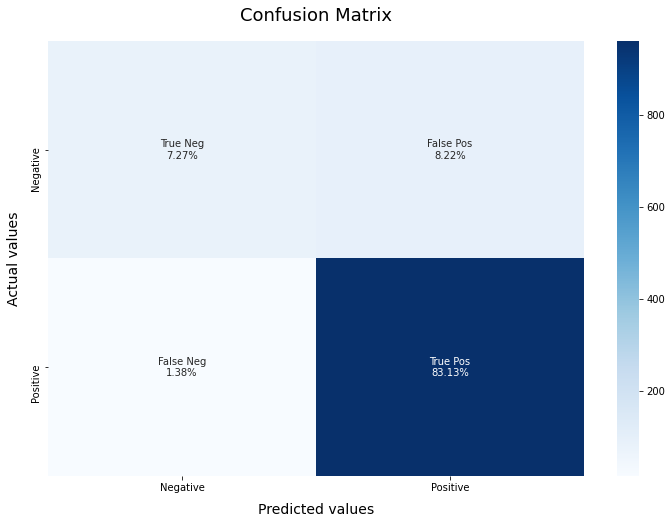

In [ ]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, y_train)

prediction['Logistic'] = clf.predict(xtest_ctv)
model_Evaluate(clf, xtest_ctv)

## TfidVectorizer

In [ ]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 2), use_idf=1, smooth_idf=1, sublinear_tf=1)

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(x_train) + list(x_test))
xtrain_tfv =  tfv.transform(x_train) 
xtest_tfv = tfv.transform(x_test)

### - Logistic Regression

0.8823529411764706
              precision    recall  f1-score   support

           0       0.98      0.25      0.39       179
           1       0.88      1.00      0.93       977

    accuracy                           0.88      1156
   macro avg       0.93      0.62      0.66      1156
weighted avg       0.89      0.88      0.85      1156



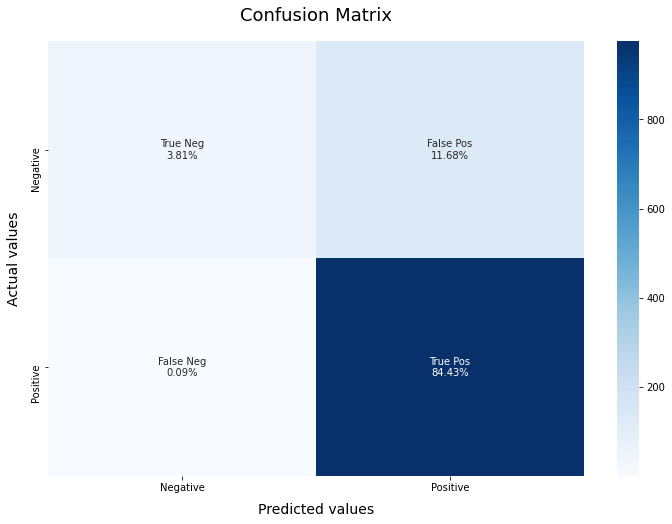

In [ ]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, y_train)

prediction['Logistic_TFIDF'] = clf.predict(xtest_tfv)
model_Evaluate(clf, xtest_tfv)

### - Naive Bayes

0.893598615916955
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       179
           1       0.93      0.94      0.94       977

    accuracy                           0.89      1156
   macro avg       0.80      0.78      0.79      1156
weighted avg       0.89      0.89      0.89      1156



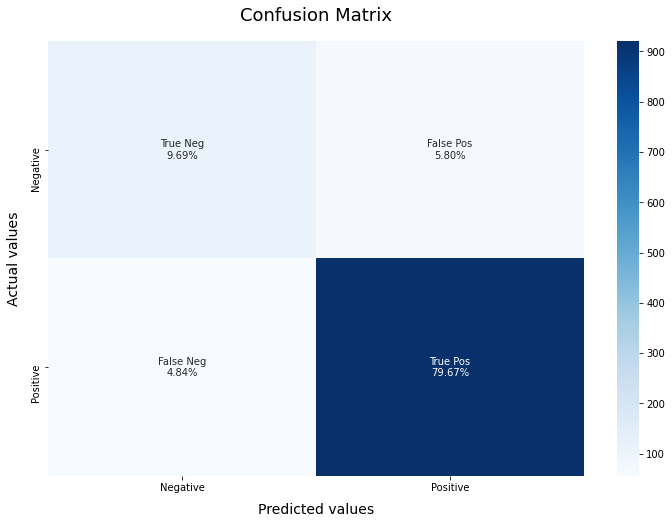

In [ ]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, y_train)

prediction['Naive Bayes'] = clf.predict(xtest_ctv)
model_Evaluate(clf, xtest_ctv)

0.8780276816608996
              precision    recall  f1-score   support

           0       1.00      0.21      0.35       179
           1       0.87      1.00      0.93       977

    accuracy                           0.88      1156
   macro avg       0.94      0.61      0.64      1156
weighted avg       0.89      0.88      0.84      1156



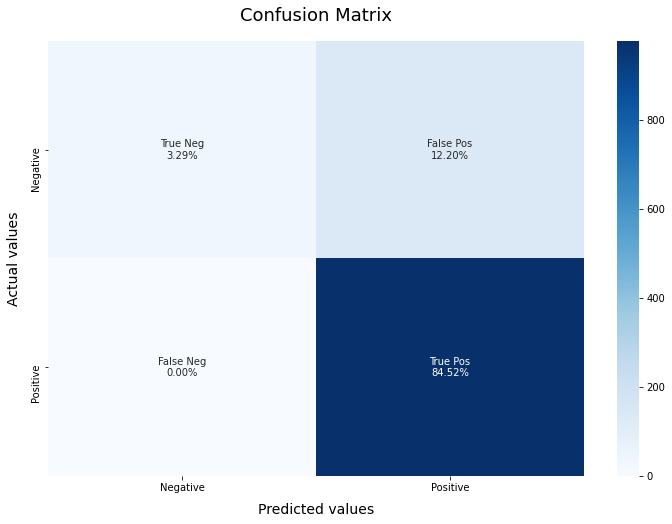

In [ ]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, y_train)

prediction['Naive Bayes_TFIDF'] = clf.predict(xtest_tfv)
model_Evaluate(clf, xtest_tfv)

### - SVM

In [ ]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xtest_svd = svd.transform(xtest_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xtest_svd_scl = scl.transform(xtest_svd)

0.8901384083044983
              precision    recall  f1-score   support

           0       0.86      0.35      0.49       179
           1       0.89      0.99      0.94       977

    accuracy                           0.89      1156
   macro avg       0.88      0.67      0.72      1156
weighted avg       0.89      0.89      0.87      1156



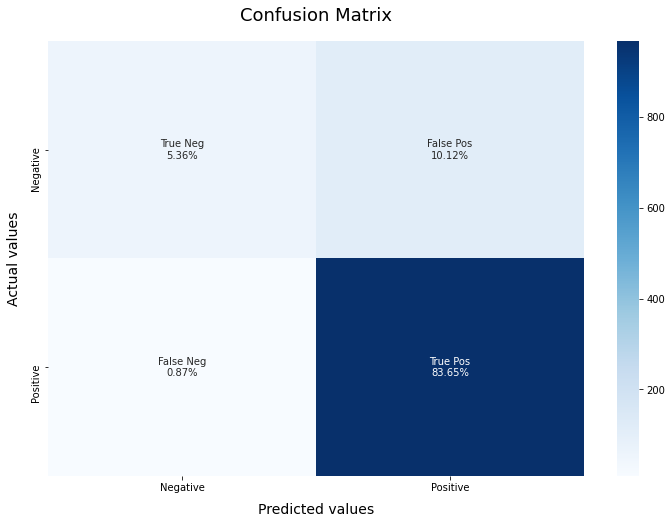

In [ ]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, y_train)

prediction['SVM_TFIDF'] = clf.predict(xtest_svd_scl)
model_Evaluate(clf, xtest_svd_scl)

### - xgboost

0.9013840830449827
              precision    recall  f1-score   support

           0       0.83      0.46      0.59       179
           1       0.91      0.98      0.94       977

    accuracy                           0.90      1156
   macro avg       0.87      0.72      0.77      1156
weighted avg       0.90      0.90      0.89      1156



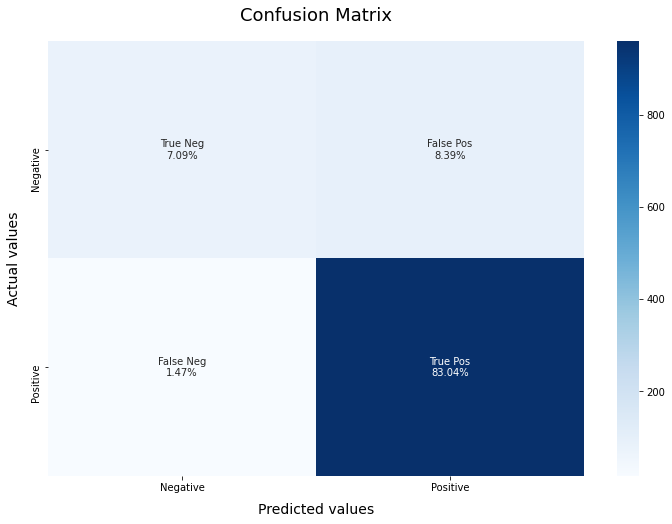

In [ ]:
# Fitting a simple xgboost on Counts
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_ctv.tocsc(), y_train)

prediction['XGboost'] = clf.predict(xtest_ctv.tocsc())
model_Evaluate(clf, xtest_ctv.tocsc())

0.8996539792387543
              precision    recall  f1-score   support

           0       0.85      0.42      0.57       179
           1       0.90      0.99      0.94       977

    accuracy                           0.90      1156
   macro avg       0.88      0.71      0.76      1156
weighted avg       0.90      0.90      0.89      1156



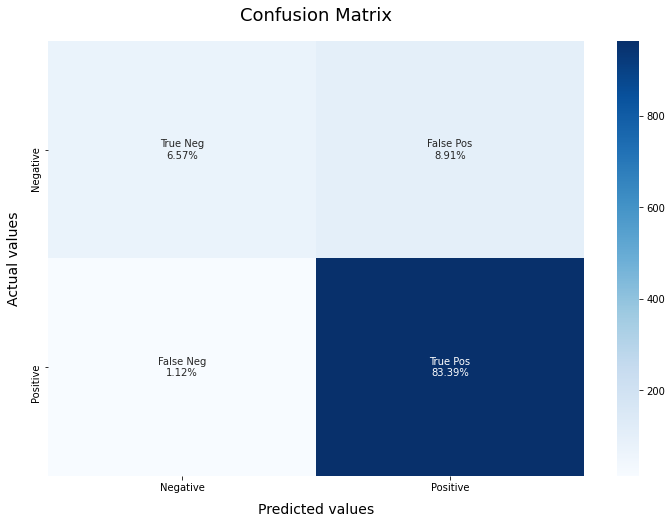

In [ ]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), y_train)

prediction['XGboost_TFIDF'] = clf.predict(xtest_tfv.tocsc())
model_Evaluate(clf, xtest_tfv.tocsc())

0.8927335640138409
              precision    recall  f1-score   support

           0       0.78      0.42      0.55       179
           1       0.90      0.98      0.94       977

    accuracy                           0.89      1156
   macro avg       0.84      0.70      0.74      1156
weighted avg       0.88      0.89      0.88      1156



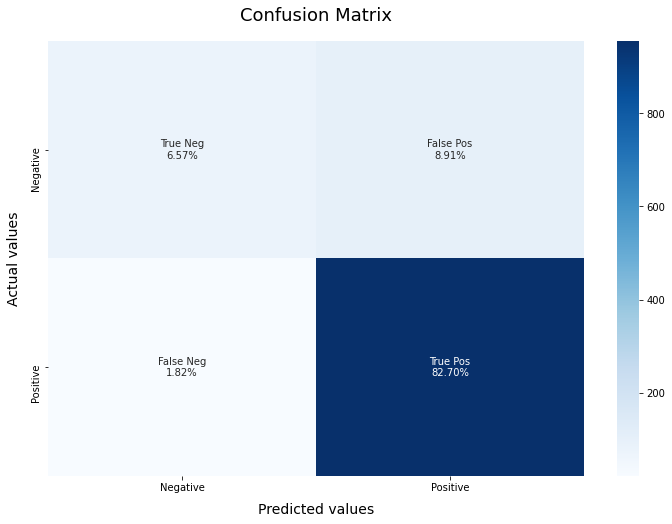

In [ ]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, y_train)

prediction['XGboost_TFIDF_SVD'] = clf.predict(xtest_svd)
model_Evaluate(clf, xtest_svd)

## Visualization - model comparision 

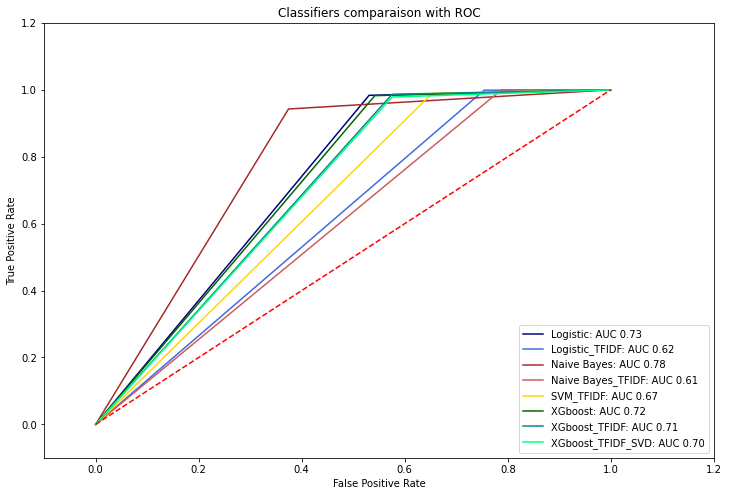

In [ ]:
cmp = 0
colors = ['navy', 'royalblue', 'brown', 'indianred', 'gold', 'darkgreen', 'darkcyan', 'springgreen']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.rc('figure', figsize=(12, 8))
plt.show()

In [ ]:
accuracy_score(y_test, prediction['Logistic'])

0.9039792387543253

In [ ]:
accuracy_score(y_test, prediction['Naive Bayes'])

0.893598615916955

In [ ]:
accuracy_score(y_test, prediction['XGboost'])

0.9013840830449827

In [ ]:
accuracy_score(y_test, prediction['XGboost_TFIDF'])

0.8996539792387543

## Visualization - coefficient 

### - Naive Bayes

In [ ]:
mul = MultinomialNB()
mul_result = mul.fit(xtrain_ctv, y_train)

features = ctv.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, mul_result.coef_[0])),
    columns = ['word', 'coefficient'])

feature_coefs = feature_coefs.sort_values(['coefficient', 'word'], ascending = [0, 1])
feature_coefs.head(20)

,word,coefficient
40073,seaweed,-4.710467
42659,snack,-4.792980
17284,flavor,-5.078421
43322,snacks,-5.166790
47195,taste,-5.296602
51135,try,-5.585935
40446,seaweed snacks,-5.739260
50792,tried,-5.758716
21589,healthy,-5.764627
11328,delicious,-5.774558


In [ ]:
print('-Top 20 positive-')
print(feature_coefs.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')        
print(feature_coefs.tail(20).to_string(index=False)) 

-Top 20 positive-
           word  coefficient
        seaweed    -4.710467
          snack    -4.792980
         flavor    -5.078421
         snacks    -5.166790
          taste    -5.296602
            try    -5.585935
 seaweed snacks    -5.739260
          tried    -5.758716
        healthy    -5.764627
      delicious    -5.774558
        product    -5.774558
           salt    -5.802900
        flavors    -5.929707
            eat    -5.970140
            buy    -5.977449
            sea    -6.012278
          salty    -6.025017
          tasty    -6.130378
          chips    -6.147619
         little    -6.150522

-Top 20 negative-
                word  coefficient
      yucky crackers   -11.991164
                 yuk   -11.991164
             yuk buy   -11.991164
           yuk never   -11.991164
               yumin   -11.991164
   yumin tummytasted   -11.991164
            yummmmmy   -11.991164
             yuppies   -11.991164
 yuppies millennials   -11.991164
         zero 

### - Logistic regression

In [ ]:
log = LogisticRegression(C=1.0)
log_result = log.fit(xtrain_ctv, y_train)

features = ctv.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, log_result.coef_[0])),
    columns = ['word', 'coefficient'])

feature_coefs = feature_coefs.sort_values(['coefficient', 'word'], ascending = [0, 1])
feature_coefs.head(20)

,word,coefficient
11328,delicious,1.555955
48105,tasty,1.193890
42659,snack,1.185757
16094,favorite,1.116974
6224,calories,1.033894
44237,son,1.008875
24337,kids,0.980758
404,addictive,0.967027
10864,daughter,0.958883
15973,fast,0.958226


In [ ]:
print('-Top 20 positive-')
print(feature_coefs.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')        
print(feature_coefs.tail(20).to_string(index=False)) 

-Top 20 positive-
      word  coefficient
 delicious     1.555955
     tasty     1.193890
     snack     1.185757
  favorite     1.116974
  calories     1.033894
       son     1.008875
      kids     0.980758
 addictive     0.967027
  daughter     0.958883
      fast     0.958226
   flavors     0.955636
      easy     0.934870
       bbq     0.849230
      keep     0.816711
     value     0.815432
       bit     0.806317
   crunchy     0.796494
    enough     0.790675
  addicted     0.777004
   healthy     0.731920

-Top 20 negative-
       word  coefficient
      fishy    -0.962678
      boxes    -0.978858
 flavor buy    -0.979575
     tasted    -1.017916
  cardboard    -1.085753
    expired    -1.106814
        fan    -1.123693
       hard    -1.125791
      threw    -1.133133
   received    -1.175385
    crushed    -1.223778
       fish    -1.238701
 disgusting    -1.249940
        box    -1.253389
     return    -1.269080
      sorry    -1.362823
      nasty    -1.580479
     crum

### - xgboost

In [ ]:
# Fitting a simple xgboost on Counts
xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb_result = xgb.fit(xtrain_ctv.tocsc(), y_train)

features = ctv.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, log_result.coef_[0])),
    columns = ['word', 'coefficient'])

feature_coefs = feature_coefs.sort_values(['coefficient', 'word'], ascending = [0, 1])
feature_coefs.head(20)

,word,coefficient
11328,delicious,1.555955
48105,tasty,1.193890
42659,snack,1.185757
16094,favorite,1.116974
6224,calories,1.033894
44237,son,1.008875
24337,kids,0.980758
404,addictive,0.967027
10864,daughter,0.958883
15973,fast,0.958226


In [ ]:
print('-Top 20 positive-')
print(feature_coefs.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')        
print(feature_coefs.tail(20).to_string(index=False)) 

-Top 20 positive-
      word  coefficient
 delicious     1.555955
     tasty     1.193890
     snack     1.185757
  favorite     1.116974
  calories     1.033894
       son     1.008875
      kids     0.980758
 addictive     0.967027
  daughter     0.958883
      fast     0.958226
   flavors     0.955636
      easy     0.934870
       bbq     0.849230
      keep     0.816711
     value     0.815432
       bit     0.806317
   crunchy     0.796494
    enough     0.790675
  addicted     0.777004
   healthy     0.731920

-Top 20 negative-
       word  coefficient
      fishy    -0.962678
      boxes    -0.978858
 flavor buy    -0.979575
     tasted    -1.017916
  cardboard    -1.085753
    expired    -1.106814
        fan    -1.123693
       hard    -1.125791
      threw    -1.133133
   received    -1.175385
    crushed    -1.223778
       fish    -1.238701
 disgusting    -1.249940
        box    -1.253389
     return    -1.269080
      sorry    -1.362823
      nasty    -1.580479
     crum

## 토픽 모델링

In [ ]:
stop = set(stopwords.words('english'))
stop.update(("b", "e", "9", "u", "n", "g"))

tokenizer = RegexpTokenizer(r'\w+')

data_text = review[['review']]

for idx in range(len(data_text)):
    data_text.iloc[idx]['review'] = [word for word in tokenizer.tokenize(data_text.iloc[idx]['review'].lower()) if word not in stop]

In [ ]:
train_ = [value[0] for value in data_text.iloc[0:].values]
num_topics = 4

In [ ]:
id2word = gensim.corpora.Dictionary(train_)
corpus = [id2word.doc2bow(text) for text in train_]
lda = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)

In [ ]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 40);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

In [ ]:
get_lda_topics(lda, num_topics)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04
0,good,snack,seaweed,snack
1,taste,snacks,flavor,seaweed
2,seaweed,flavor,try,great
3,great,seaweed,love,flavor
4,like,like,snacks,really
5,would,healthy,like,loved
6,product,good,salt,product
7,delicious,love,would,good
8,flavor,great,taste,sea
9,snack,delicious,sea,bacon


In [ ]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
pyLDAvis.display(vis)

## 네트워크 분석

In [ ]:
review['title'] = review['review'].map(lambda x : re.sub("[^a-zA-Z]", " ", x))
tokenized_title = review['title'].apply(lambda x : str(x).split())
tagged_sents = [nltk.pos_tag(sentence) for sentence in tokenized_title]
noun_phrases = [[token for token, tag in sent if re.match(r'NN*|JJ*', tag)] 
                for sent in tagged_sents]

In [ ]:
title = pd.DataFrame()
title['noun'] = noun_phrases

In [ ]:
word_list = list(itertools.chain.from_iterable(title['noun'] .to_list()))

In [ ]:
# 한 글자 단어 제거
index = []
for k in range(len(word_list)):
    if len(word_list[k]) == 1:
        index.append(k)

index.sort(reverse = True)

for num in index:
    del word_list[num]

In [ ]:
c = Counter(word_list)
common_word = c.most_common(100)

In [ ]:
mask_word = []
for word, count in common_word:
     mask_word.append(word)

In [ ]:
def masking(word_list):
    data_list = []
    for word in word_list:
        if word in mask_word:
            data_list.append(word)
    return data_list

In [ ]:
wdf = pd.DataFrame()
wdf['noun'] = title['noun'].map(lambda x : masking(x))
wdf['noun_sents'] = title['noun'].map(lambda x : ' '.join(x))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer # frequency based DTM

count_vec = CountVectorizer(min_df = 1, ngram_range = (1,1))

In [ ]:
X = count_vec.fit_transform(wdf['noun_sents'])

In [ ]:
Xc = (X.T * X) # 동시등장행렬 계산
Xc.setdiag(0) #  # 자신과 자신의 동시등장은 계산하지 않음

In [ ]:
mat = pd.DataFrame(Xc.todense()); mat

,0,1,2,3,4,5,6,7,8,9,...,4810,4811,4812,4813,4814,4815,4816,4817,4818,4819
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4816,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4817,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
co_mat = pd.DataFrame(np.tril(mat)); co_mat

,0,1,2,3,4,5,6,7,8,9,...,4810,4811,4812,4813,4814,4815,4816,4817,4818,4819
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4816,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4817,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 0을 null값으로 대체

co_mat.replace(to_replace=0, value=np.nan, inplace = True)

In [ ]:
# Network 분석에 쓰일 Edge; 이후 작업을 위해 Stack
edge_df = co_mat.stack().reset_index()
edge_df.columns = ['Source', 'Target', 'Weight'] ; edge_df

,Source,Target,Weight
0,13,2,1.0
1,17,1,1.0
2,23,2,1.0
3,25,2,1.0
4,25,13,1.0
...,...,...,...
248568,4819,3921,1.0
248569,4819,4118,1.0
248570,4819,4175,1.0
248571,4819,4283,2.0


In [ ]:
# 단어 정수 인코딩
names = count_vec.get_feature_names()

word_dic = {}
for i , word in enumerate(names):
    word_dic[i] = word

In [ ]:
# Network 분석에 쓰일 Node

node_df = pd.DataFrame(range(np.max(edge_df['Source']+1)), columns = ['Id'])
node_df['Label'] = node_df['Id'].map(lambda x : word_dic[x]) ; node_df

,Id,Label
0,0,abd
1,1,ability
2,2,able
3,3,abnormal
4,4,above
...,...,...
4815,4815,ziploc
4816,4816,ziplock
4817,4817,zipper
4818,4818,zone


In [ ]:
g = nx.from_pandas_edgelist(edge_df, 'Source', 'Target', create_using= nx.Graph())

In [ ]:
from community import community_louvain

# 클러스터 분류
partition = community_louvain.best_partition(g, resolution=0.5)

In [ ]:
len(set(partition.values()))

74

In [ ]:
com_df = pd.DataFrame(partition, index = ['Partition'])
com_df = com_df.transpose().reset_index()
com_df.columns = ['Id', 'Partition'] ; com_df

,Id,Partition
0,13,0
1,2,1
2,17,2
3,1,2
4,23,3
...,...,...
4801,4815,28
4802,4816,28
4803,4817,52
4804,4818,63


In [ ]:
node_df = node_df.merge(com_df)
node_df = node_df.sort_values('Partition') ; node_df

,Id,Label,Partition
48,49,advantages,0
195,196,areas,0
1247,1250,dyes,0
1244,1247,dusting,0
4465,4476,unpleasant,0
...,...,...,...
440,443,bother,73
526,529,bus,73
4549,4560,vice,73
2087,2095,insert,73


In [ ]:
part_df = node_df.copy()

part_df.columns = ['Source', 'Label', 'Partition']
edge_df[['Source_Partition','Source_Label']] = edge_df.merge(part_df)[['Partition', 'Label']]


part_df.columns = ['Target', 'Label', 'Partition']
edge_df = edge_df.merge(part_df)
edge_df.columns = ['Source', 'Target', 'Weight', 'Source_Partition', 'Source_Label', 'Target_Label', 'Target_Partition']; edge_df

,Source,Target,Weight,Source_Partition,Source_Label,Target_Label,Target_Partition
0,13,2,1.0,0,access,able,1
1,23,2,1.0,3,acquired,able,1
2,25,2,1.0,4,actual,able,1
3,32,2,1.0,7,addicting,able,1
4,60,2,1.0,13,affordable,able,1
...,...,...,...,...,...,...,...
248568,4808,4784,1.0,5,yummy,young,5
248569,4810,4606,1.0,29,zero,wary,29
248570,4814,4378,1.0,15,zip,triangle,15
248571,4816,4705,1.0,28,ziplock,wiser,28


In [ ]:
dge_df = edge_df[['Source', 'Target', 'Weight', 'Source_Partition', 'Source_Label', 'Target_Partition', 'Target_Label']]; edge_df

,Source,Target,Weight,Source_Partition,Source_Label,Target_Label,Target_Partition
0,13,2,1.0,0,access,able,1
1,23,2,1.0,3,acquired,able,1
2,25,2,1.0,4,actual,able,1
3,32,2,1.0,7,addicting,able,1
4,60,2,1.0,13,affordable,able,1
...,...,...,...,...,...,...,...
248568,4808,4784,1.0,5,yummy,young,5
248569,4810,4606,1.0,29,zero,wary,29
248570,4814,4378,1.0,15,zip,triangle,15
248571,4816,4705,1.0,28,ziplock,wiser,28
